In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import datetime

plt.style.use('seaborn-whitegrid')

# GPU 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CNN Stacked Autoencoder 정의
class CNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(CNNAutoencoder, self).__init__()

        # 인코더 (Encoder)
        self.encoder_conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.encoder_conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * input_size, hidden_size)  # 인코더 최종 출력으로 변환
        self.fc2 = nn.Linear(hidden_size, latent_size)  # 잠재 공간으로 변환

        # 디코더 (Decoder)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 32 * input_size)
        self.decoder_conv1 = nn.Conv1d(32, 16, kernel_size=3, padding=1)
        self.decoder_conv2 = nn.Conv1d(16, 1, kernel_size=3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더
        x = self.encoder_conv1(x)
        x = self.relu(x)
        x = self.encoder_conv2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        # 잠재 공간 (Latent Space)
        latent_code = x

        # 디코더
        x = self.fc3(latent_code)
        x = self.relu(x)
        x = self.fc4(x)
        x = x.view(x.size(0), 32, -1)
        x = self.decoder_conv1(x)
        x = self.relu(x)
        x = self.decoder_conv2(x)

        return x, latent_code

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, latent_size):
        super(CNN, self).__init__()
        self.autoencoder = CNNAutoencoder(input_size, hidden_size, latent_size)
        self.fc = nn.Linear(latent_size, num_classes)

    def forward(self, x):
        x, latent_code = self.autoencoder(x)
        output = self.fc(latent_code)
        return output

# 반복 루프
for iteration in range(1):
    print(f"=========== Iteration {iteration + 1} ===========")

    # QQQ 주가 데이터 다운로드
    df = pd.read_csv('qqq_2000.csv', parse_dates=['Date'], index_col='Date')

    # 2004년 1월 1일부터의 데이터만 필터링
    df = df[df.index >= '2004-01-01']

    # 전체 데이터를 Feature로 사용하고, 마지막 값 제외하여 타겟 설정
    X = df[['Adj Close']].values[:-1]  # 마지막 값 제외하고 Feature로 사용
    y = df[['Adj Close']].values[1:]   # 첫 번째 값을 제외하고 타겟으로 사용


    # 로그 차분 적용
    y_log = np.log(X)
    y_diff = np.diff(y_log, axis=0)

    # Torch 텐서로 변환
    X_train_tensors = Variable(torch.Tensor(y_diff)).to(device)
    y_train_tensors = Variable(torch.Tensor(y_diff)).to(device)

    # 데이터 차원을 (batch_size, in_channels, seq_len)으로 변경
    X_train_tensors_f = X_train_tensors.unsqueeze(1)  # in_channels 차원을 추가

    # 모델 학습
    num_epochs = 10000
    lr = 0.001

    model = CNN(num_classes=1, input_size=1, hidden_size=128, latent_size=64).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensors_f)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train_tensors)
        loss.backward()
        optimizer.step()

        # 100 에포크마다 손실 출력
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_train_tensors_f)
                test_loss = criterion(test_outputs, y_train_tensors)
            print(f'Epoch {epoch:>6}, Train Loss: {loss.item():.10f}, Test Loss: {test_loss.item():.10f}')

    # 전체 데이터로 다음 날 예측
    model.eval()
    with torch.no_grad():
        next_day_diff_scaled = model(y_train_tensors.unsqueeze(1)).cpu().detach().numpy()[-1]

    # 로그 차분 복원
    last_log_value = y_log[-1][0]
    next_day_diff = next_day_diff_scaled
    next_day_log_value = last_log_value + next_day_diff
    next_day_predicted_price = np.exp(next_day_log_value).item()

    # 마지막 실제 값과 예측된 다음 날 값 출력
    last_actual_price = y[-1][0]
    last_actual_date = df.index[-1]  # 마지막 날짜를 추출

    # 시각화
    plt.figure(figsize=(10, 6))

    # 실제 값 그래프 그리기
    plt.plot(df['Adj Close'], label='Actual Price')

    # 예측된 다음 날 값 따로 플로팅
    plt.scatter(df.index[-1], next_day_predicted_price, color='red', label='Predicted Next Day Price', zorder=5)

    # pred.csv 파일이 있는 경우 불러와서 함께 플로팅
    try:
        pred_df = pd.read_csv('pred.csv', parse_dates=['Date'])
        plt.plot(pd.to_datetime(pred_df['Date']), pred_df['Predicted Adj Close'], label='Previous Predictions',  color='red')
    except FileNotFoundError:
        print("pred.csv 파일이 없습니다. 새로운 파일을 생성합니다.")

    # x축을 2023년 이후부터 현재 데이터의 마지막 날짜 + 5일로 설정
    end_date = df.index[-1] + pd.Timedelta(days=5)
    plt.xlim(pd.Timestamp('2023-01-01'), end_date)


    # y축 범위를 데이터의 최소/최대 값으로 설정 (x축 범위 내의 데이터에 맞춤)
    subset = df.loc['2023-01-01':]
    y_min = subset['Adj Close'].min() * 0.95  # 최소값보다 5% 작게
    y_max = subset['Adj Close'].max() * 1.05  # 최대값보다 5% 크게
    plt.ylim(y_min, y_max)

    # 그래프 제목 및 레전드 설정
    plt.title(f'CNN Prediction Model with Autoencoder - Next Day Forecast (Iteration {iteration + 1})')
    plt.legend()


    # 특정 폴더에 저장
    save_dir = 'charts'  # 폴더 이름 설정
    os.makedirs(save_dir, exist_ok=True)  # 폴더가 없으면 생성

    # 그래프 제목 및 레전드 설정
    plt.title(f'CNN Prediction Model with Autoencoder - Next Day Forecast (Iteration {iteration + 1})')
    plt.legend()

    # 그래프 저장
    chart_path = os.path.join(save_dir, f'forecast_iteration_{iteration + 1}.png')
    plt.savefig(chart_path)

    # 그래프 표시
    plt.show()


    # qqq_2000 파일 업데이트
    original_df = pd.read_csv('qqq_2000Original.csv', parse_dates=['Date'], index_col='Date')
    next_day_in_original = original_df.index[original_df.index > df.index[-1]][0]
    next_day_adj_close = original_df.loc[next_day_in_original, 'Adj Close']
    # qqq_2000.csv에 새로운 날짜와 Adj Close 값 추가
    df.loc[next_day_in_original, 'Adj Close'] = next_day_adj_close

    # 업데이트된 DataFrame을 CSV 파일로 저장 (pred 컬럼은 저장하지 않음)
    df.to_csv('qqq_2000.csv', columns=['Adj Close'])


    # 예측 결과 출력
    print(f"예측결과 (Iteration {iteration + 1}) ==================================================")
    print("qqq_2000.csv 마지막 날짜             :", df.index[-2])
    print("qqq_2000Original.csv의 다음날        :", next_day_in_original)
    print("마지막 실제 데이터 값                :", last_actual_price)
    print("qqq_2000Original.csv의 다음날 실제값 :", next_day_adj_close)
    print("qqq_2000Original.csv의 다음날 예측값 :", round(next_day_predicted_price, 2))
    
    print()
    print("업데이트된 qqq_2000.csv 파일:")
    print(df.tail())
    
    
    # pred.csv 파일을 불러오기 (파일이 없을 경우 새로운 DataFrame 생성)
    try:
        pred_df = pd.read_csv('pred.csv')
    except FileNotFoundError:
        pred_df = pd.DataFrame(columns=['Date', 'Predicted Adj Close'])

    # 마지막 실제 날짜 및 예측된 날짜와 값 추가
    next_day_date = next_day_in_original


    # 새로운 데이터
    new_data = {
        'Date': [next_day_in_original.strftime('%Y-%m-%d')],  # 날짜 형식을 YYYY-MM-DD로 지정
        'Predicted Adj Close': [next_day_predicted_price]
    }


    # 새로운 행을 DataFrame으로 변환
    new_row_df = pd.DataFrame(new_data)

    # 기존 pred.csv 파일에 새로운 행 추가
    pred_df = pd.concat([pred_df, new_row_df], ignore_index=True)

    # 업데이트된 DataFrame을 다시 pred.csv 파일에 저장
    pred_df.to_csv('pred.csv', index=False)

    print()
    print(f"업데이트된 pred.csv 파일 (Iteration {iteration + 1}):")
    print(pred_df.tail())


In [19]:
import pandas as pd

# pred.csv 파일 읽기
pred_df = pd.read_csv('pred.csv', parse_dates=['Date'])
pred_df = pred_df[['Date', 'Predicted Adj Close']]
pred_df.columns = ['Date', 'pred']  # 칼럼 이름을 Date, pred로 변경

# qqq_2000.csv 파일 읽기 (2024년도부터)
qqq_df = pd.read_csv('qqq_2000.csv', parse_dates=['Date'])
qqq_df = qqq_df[qqq_df['Date'] >= '2024-01-01'][['Date', 'Adj Close']]
qqq_df.columns = ['Date', 'close']  # 칼럼 이름을 Date, close로 변경

# 두 데이터프레임을 Date를 기준으로 합치기 (outer join)
df = pd.merge(pred_df, qqq_df, on='Date', how='outer')

# 결과 출력
print(df.head())

# df를 CSV 파일로 저장
df.to_csv('result.csv', index=False)



        Date        pred       close
0 2024-01-02  409.902039  401.420319
1 2024-01-03  406.564819  397.172699
2 2024-01-04  394.622467  395.128662
3 2024-01-05  392.980713  395.597290
4 2024-01-08  392.356659  403.773499


Initial Buy: 2491 shares at 401.4203186035156
최종 수익률 (매매 전략): 20.48%
최종 수익률 (Buy and Hold): 21.25%
거래 내역이 'transactions_history2.csv' 파일로 저장되었습니다.


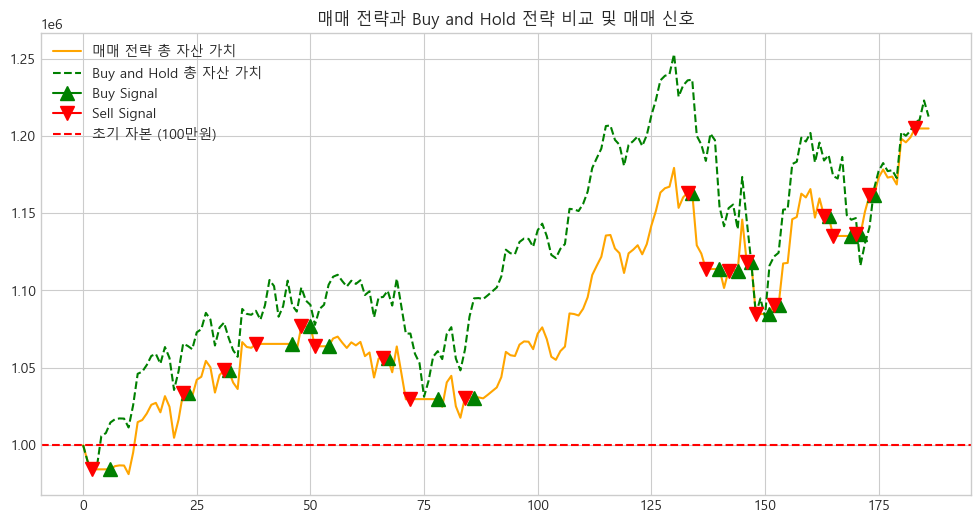

In [23]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows인 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지는 것을 방지




# 단순 이동평균(SMA) 계산 함수
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

# 과거 N일간 수익률 계산 함수
def calculate_past_return(data, days=5):
    return (data - data.shift(days)) / data.shift(days) * 100


predicted = df['pred'].values

# 초기 자본 및 상태 설정
initial_capital = 1000000  # 초기 자본 100만원
capital = initial_capital
shares = 0  # 보유 주식 수
transactions = []  # 각 일자별 거래 내역 저장
total_value_history = []  # 총 자산(현금+주식)의 역사

# 1. 초기 자본으로 100% 매수
# train_size를 0으로 설정하여 데이터를 처음부터 사용
train_size = 0  

initial_buy_price = df['close'].iloc[train_size]
shares = int(capital / initial_buy_price)  # 초기 자본으로 매수 가능한 정수 주식 수
capital = capital - (shares * initial_buy_price)  # 남은 자본 (소수점 제외)
transactions.append((df.index[train_size], 'Initial Buy', shares, initial_buy_price, capital))
print(f"Initial Buy: {shares} shares at {initial_buy_price}")

# 매수 후 초기 자산(총 자산 = 보유 주식의 가치)
initial_total_value = shares * initial_buy_price
total_value_history.append(initial_total_value)

# 매수/매도 신호 기록
buy_signals = []
sell_signals = []

# 매수 및 매도 전략 수행 (예측값을 기준으로)
for i in range(train_size + 1, len(predicted)):
    close_price = df['close'].iloc[i]
    predicted_today = predicted[i]
    predicted_yesterday = predicted[i - 1]
    
    # 매수 조건: 예측값이 전일 예측값보다 1% 이상 상승할 때
    if predicted_today > predicted_yesterday * 1.025:
        if capital > 0:
            buy_shares = int(capital / close_price)  # 매수 가능한 정수 주식 수
            if buy_shares >= 1:  # 최소 1주 이상만 매수 가능
                capital -= buy_shares * close_price
                shares += buy_shares
                transactions.append((df.index[i], 'Buy', buy_shares, close_price, capital))
                buy_signals.append((df.index[i], close_price))
    
    # 매도 조건: 예측값이 전일 예측값보다 1% 이상 하락할 때
    elif predicted_today < predicted_yesterday * 0.975:
            sell_shares = shares  # 전량 매도
            if sell_shares >= 1:  # 최소 1주 이상만 매도 가능
                capital += sell_shares * close_price
                shares = 0
                transactions.append((df.index[i], 'Sell', sell_shares, close_price, capital))
                sell_signals.append((df.index[i], close_price))
    
    # 총 자산 계산 (현금 + 보유 주식의 현재 가치)
    total_value = capital + shares * close_price
    total_value_history.append(total_value)

# Buy and Hold 전략
buy_hold_shares = int(initial_capital / df['close'].iloc[train_size])
buy_hold_value_history = df['close'].iloc[train_size:] * buy_hold_shares

# 수익률 계산
total_return = (total_value_history[-1] - initial_capital) / initial_capital * 100
buy_hold_return = (buy_hold_value_history.iloc[-1] - initial_capital) / initial_capital * 100
print(f"최종 수익률 (매매 전략): {total_return:.2f}%")
print(f"최종 수익률 (Buy and Hold): {buy_hold_return:.2f}%")


# 거래 내역을 pandas DataFrame으로 변환
transactions_df = pd.DataFrame(transactions, columns=['날짜', '유형', '주식 수', '가격', '남은 자본'])

# 거래 내역을 CSV 파일로 저장
transactions_df.to_csv('transactions_history2.csv', index=False, encoding='utf-8-sig')

print("거래 내역이 'transactions_history2.csv' 파일로 저장되었습니다.")

# 매매 전략과 Buy and Hold 전략 비교 시각화 (하나의 차트로 합치기)
plt.figure(figsize=(12, 6))

# 매매 전략의 총 자산 가치 (x축과 y축의 길이가 일치하도록 슬라이스)
plt.plot(df.index[train_size:train_size+len(total_value_history)], total_value_history[:len(df.index[train_size:])], label='매매 전략 총 자산 가치', color='orange')

# Buy and Hold 전략의 자산 가치
plt.plot(buy_hold_value_history.index, buy_hold_value_history.values, label='Buy and Hold 총 자산 가치', linestyle='--', color='green')

# 매수/매도 시점 표시 (매매 전략 총 자산 가치의 y축에 맞추기)
# 매수 신호는 처음 한 번만 레전드에 추가
first_buy_signal = True
for i, buy_signal in enumerate(buy_signals):
    buy_index = df.index.get_loc(buy_signal[0])  # buy_signal[0]은 신호가 발생한 날짜
    total_value_at_buy = total_value_history[buy_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_buy_signal:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10, label='Buy Signal')
        first_buy_signal = False
    else:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10)

# 매도 신호는 처음 한 번만 레전드에 추가
first_sell_signal = True
for i, sell_signal in enumerate(sell_signals):
    sell_index = df.index.get_loc(sell_signal[0])  # sell_signal[0]은 신호가 발생한 날짜
    total_value_at_sell = total_value_history[sell_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_sell_signal:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10, label='Sell Signal')
        first_sell_signal = False
    else:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10)

# 초기 자본 기준선
plt.axhline(initial_capital, color='r', linestyle='--', label='초기 자본 (100만원)')

plt.title('매매 전략과 Buy and Hold 전략 비교 및 매매 신호')
plt.legend()
plt.show()


Initial Buy: 2491 shares at 401.4203186035156
최종 수익률 (매매 전략): 20.48%
최종 수익률 (Buy and Hold): 21.25%
거래 내역이 'transactions_history2.csv' 파일로 저장되었습니다.


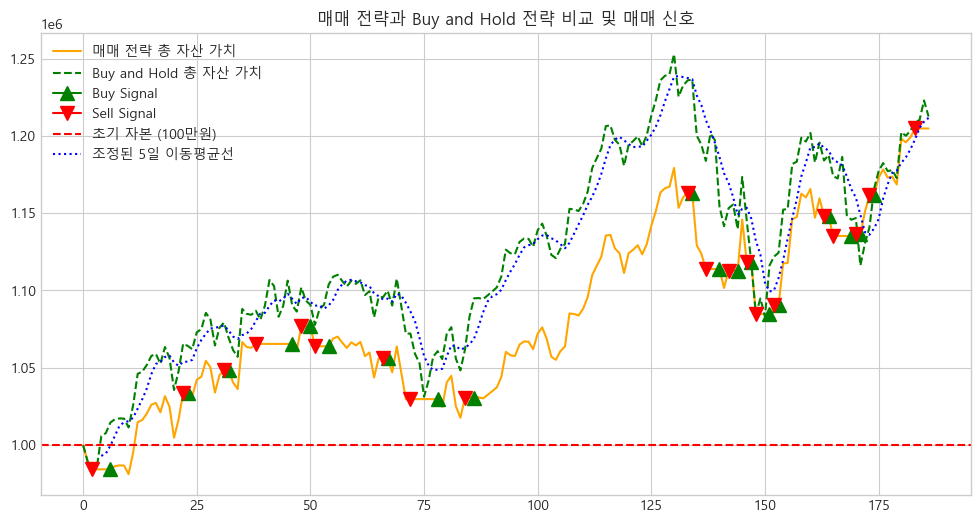

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows인 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지는 것을 방지




# 단순 이동평균(SMA) 계산 함수
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

# 과거 N일간 수익률 계산 함수
def calculate_past_return(data, days=5):
    return (data - data.shift(days)) / data.shift(days) * 100


predicted = df['pred'].values

# 초기 자본 및 상태 설정
initial_capital = 1000000  # 초기 자본 100만원
capital = initial_capital
shares = 0  # 보유 주식 수
transactions = []  # 각 일자별 거래 내역 저장
total_value_history = []  # 총 자산(현금+주식)의 역사

# 1. 초기 자본으로 100% 매수
# train_size를 0으로 설정하여 데이터를 처음부터 사용
train_size = 0  

initial_buy_price = df['close'].iloc[train_size]
shares = int(capital / initial_buy_price)  # 초기 자본으로 매수 가능한 정수 주식 수
capital = capital - (shares * initial_buy_price)  # 남은 자본 (소수점 제외)
transactions.append((df.index[train_size], 'Initial Buy', shares, initial_buy_price, capital))
print(f"Initial Buy: {shares} shares at {initial_buy_price}")

# 매수 후 초기 자산(총 자산 = 보유 주식의 가치)
initial_total_value = shares * initial_buy_price
total_value_history.append(initial_total_value)

# 매수/매도 신호 기록
buy_signals = []
sell_signals = []

# 매수 및 매도 전략 수행 (예측값을 기준으로)
for i in range(train_size + 1, len(predicted)):
    close_price = df['close'].iloc[i]
    predicted_today = predicted[i]
    predicted_yesterday = predicted[i - 1]
    
    # 매수 조건: 예측값이 전일 예측값보다 1% 이상 상승할 때
    if predicted_today > predicted_yesterday * 1.025:
        if capital > 0:
            buy_shares = int(capital / close_price)  # 매수 가능한 정수 주식 수
            if buy_shares >= 1:  # 최소 1주 이상만 매수 가능
                capital -= buy_shares * close_price
                shares += buy_shares
                transactions.append((df.index[i], 'Buy', buy_shares, close_price, capital))
                buy_signals.append((df.index[i], close_price))
    
    # 매도 조건: 예측값이 전일 예측값보다 1% 이상 하락할 때
    elif predicted_today < predicted_yesterday * 0.975:
            sell_shares = shares  # 전량 매도
            if sell_shares >= 1:  # 최소 1주 이상만 매도 가능
                capital += sell_shares * close_price
                shares = 0
                transactions.append((df.index[i], 'Sell', sell_shares, close_price, capital))
                sell_signals.append((df.index[i], close_price))
    
    # 총 자산 계산 (현금 + 보유 주식의 현재 가치)
    total_value = capital + shares * close_price
    total_value_history.append(total_value)

# Buy and Hold 전략
buy_hold_shares = int(initial_capital / df['close'].iloc[train_size])
buy_hold_value_history = df['close'].iloc[train_size:] * buy_hold_shares

# 수익률 계산
total_return = (total_value_history[-1] - initial_capital) / initial_capital * 100
buy_hold_return = (buy_hold_value_history.iloc[-1] - initial_capital) / initial_capital * 100
print(f"최종 수익률 (매매 전략): {total_return:.2f}%")
print(f"최종 수익률 (Buy and Hold): {buy_hold_return:.2f}%")


# 거래 내역을 pandas DataFrame으로 변환
transactions_df = pd.DataFrame(transactions, columns=['날짜', '유형', '주식 수', '가격', '남은 자본'])

# 거래 내역을 CSV 파일로 저장
transactions_df.to_csv('transactions_history2.csv', index=False, encoding='utf-8-sig')

print("거래 내역이 'transactions_history2.csv' 파일로 저장되었습니다.")

# 매매 전략과 Buy and Hold 전략 비교 시각화 (하나의 차트로 합치기)
plt.figure(figsize=(12, 6))

# 매매 전략의 총 자산 가치 (x축과 y축의 길이가 일치하도록 슬라이스)
plt.plot(df.index[train_size:train_size+len(total_value_history)], total_value_history[:len(df.index[train_size:])], label='매매 전략 총 자산 가치', color='orange')

# Buy and Hold 전략의 자산 가치
plt.plot(buy_hold_value_history.index, buy_hold_value_history.values, label='Buy and Hold 총 자산 가치', linestyle='--', color='green')

# 매수/매도 시점 표시 (매매 전략 총 자산 가치의 y축에 맞추기)
# 매수 신호는 처음 한 번만 레전드에 추가
first_buy_signal = True
for i, buy_signal in enumerate(buy_signals):
    buy_index = df.index.get_loc(buy_signal[0])  # buy_signal[0]은 신호가 발생한 날짜
    total_value_at_buy = total_value_history[buy_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_buy_signal:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10, label='Buy Signal')
        first_buy_signal = False
    else:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10)

# 매도 신호는 처음 한 번만 레전드에 추가
first_sell_signal = True
for i, sell_signal in enumerate(sell_signals):
    sell_index = df.index.get_loc(sell_signal[0])  # sell_signal[0]은 신호가 발생한 날짜
    total_value_at_sell = total_value_history[sell_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_sell_signal:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10, label='Sell Signal')
        first_sell_signal = False
    else:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10)

# 초기 자본 기준선
plt.axhline(initial_capital, color='r', linestyle='--', label='초기 자본 (100만원)')


# 5일 이동평균선 계산 및 플로팅 (초기 자본을 기준으로 조정된 값으로 계산)
df['adjusted_close'] = df['close'] * (initial_capital / df['close'].iloc[0])
sma_5 = df['adjusted_close'].rolling(window=5).mean()
plt.plot(df.index, sma_5, label='조정된 5일 이동평균선', linestyle=':', color='blue')

plt.title('매매 전략과 Buy and Hold 전략 비교 및 매매 신호')
plt.legend()
plt.show()


Initial Buy: 2491 shares at 401.4203186035156
최종 수익률 (매매 전략): 30.53%
최종 수익률 (Buy and Hold): 21.25%
거래 내역이 'transactions_history2.csv' 파일로 저장되었습니다.


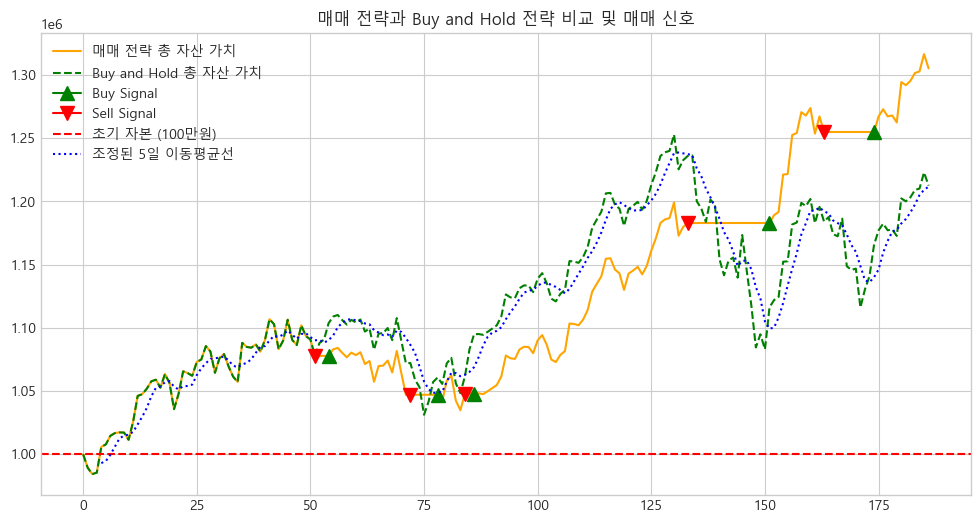

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows인 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지는 것을 방지




# 단순 이동평균(SMA) 계산 함수
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

# 과거 N일간 수익률 계산 함수
def calculate_past_return(data, days=5):
    return (data - data.shift(days)) / data.shift(days) * 100


predicted = df['pred'].values

# 초기 자본 및 상태 설정
initial_capital = 1000000  # 초기 자본 100만원
capital = initial_capital
shares = 0  # 보유 주식 수
transactions = []  # 각 일자별 거래 내역 저장
total_value_history = []  # 총 자산(현금+주식)의 역사

# 1. 초기 자본으로 100% 매수
# train_size를 0으로 설정하여 데이터를 처음부터 사용
train_size = 0  

initial_buy_price = df['close'].iloc[train_size]
shares = int(capital / initial_buy_price)  # 초기 자본으로 매수 가능한 정수 주식 수
capital = capital - (shares * initial_buy_price)  # 남은 자본 (소수점 제외)
transactions.append((df.index[train_size], 'Initial Buy', shares, initial_buy_price, capital))
print(f"Initial Buy: {shares} shares at {initial_buy_price}")

# 매수 후 초기 자산(총 자산 = 보유 주식의 가치)
initial_total_value = shares * initial_buy_price
total_value_history.append(initial_total_value)

# 매수/매도 신호 기록
buy_signals = []
sell_signals = []
sma_5 = df['close'].rolling(window=5).mean()

# 매수 및 매도 전략 수행 (예측값을 기준으로)
for i in range(train_size + 1, len(predicted)):
    close_price = df['close'].iloc[i]
    predicted_today = predicted[i]
    predicted_yesterday = predicted[i - 1]
    sma_5_today = sma_5.iloc[i]  # 5일 이동평균선 값
    
    # 매수 조건: 예측값이 전일 예측값보다 1% 이상 상승하고 종가가 5일 이동평균선보다 클 때
    if predicted_today > predicted_yesterday * 1.025 and close_price > sma_5_today:
        if capital > 0:
            buy_shares = int(capital / close_price)  # 매수 가능한 정수 주식 수
            if buy_shares >= 1:  # 최소 1주 이상만 매수 가능
                capital -= buy_shares * close_price
                shares += buy_shares
                transactions.append((df.index[i], 'Buy', buy_shares, close_price, capital))
                buy_signals.append((df.index[i], close_price))
    
    # 매도 조건: 예측값이 전일 예측값보다 1% 이상 하락하고 종가가 5일 이동평균선보다 작을 때
    elif predicted_today < predicted_yesterday * 0.975 and close_price < sma_5_today:
            sell_shares = shares  # 전량 매도
            if sell_shares >= 1:  # 최소 1주 이상만 매도 가능
                capital += sell_shares * close_price
                shares = 0
                transactions.append((df.index[i], 'Sell', sell_shares, close_price, capital))
                sell_signals.append((df.index[i], close_price))
    
    # 총 자산 계산 (현금 + 보유 주식의 현재 가치)
    total_value = capital + shares * close_price
    total_value_history.append(total_value)

# Buy and Hold 전략
buy_hold_shares = int(initial_capital / df['close'].iloc[train_size])
buy_hold_value_history = df['close'].iloc[train_size:] * buy_hold_shares

# 수익률 계산
total_return = (total_value_history[-1] - initial_capital) / initial_capital * 100
buy_hold_return = (buy_hold_value_history.iloc[-1] - initial_capital) / initial_capital * 100
print(f"최종 수익률 (매매 전략): {total_return:.2f}%")
print(f"최종 수익률 (Buy and Hold): {buy_hold_return:.2f}%")


# 거래 내역을 pandas DataFrame으로 변환
transactions_df = pd.DataFrame(transactions, columns=['날짜', '유형', '주식 수', '가격', '남은 자본'])

# 거래 내역을 CSV 파일로 저장
transactions_df.to_csv('transactions_history2.csv', index=False, encoding='utf-8-sig')

print("거래 내역이 'transactions_history2.csv' 파일로 저장되었습니다.")

# 매매 전략과 Buy and Hold 전략 비교 시각화 (하나의 차트로 합치기)
plt.figure(figsize=(12, 6))

# 매매 전략의 총 자산 가치 (x축과 y축의 길이가 일치하도록 슬라이스)
plt.plot(df.index[train_size:train_size+len(total_value_history)], total_value_history[:len(df.index[train_size:])], label='매매 전략 총 자산 가치', color='orange')

# Buy and Hold 전략의 자산 가치
plt.plot(buy_hold_value_history.index, buy_hold_value_history.values, label='Buy and Hold 총 자산 가치', linestyle='--', color='green')

# 매수/매도 시점 표시 (매매 전략 총 자산 가치의 y축에 맞추기)
# 매수 신호는 처음 한 번만 레전드에 추가
first_buy_signal = True
for i, buy_signal in enumerate(buy_signals):
    buy_index = df.index.get_loc(buy_signal[0])  # buy_signal[0]은 신호가 발생한 날짜
    total_value_at_buy = total_value_history[buy_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_buy_signal:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10, label='Buy Signal')
        first_buy_signal = False
    else:
        plt.plot(buy_signal[0], total_value_at_buy, marker='^', color='green', markersize=10)

# 매도 신호는 처음 한 번만 레전드에 추가
first_sell_signal = True
for i, sell_signal in enumerate(sell_signals):
    sell_index = df.index.get_loc(sell_signal[0])  # sell_signal[0]은 신호가 발생한 날짜
    total_value_at_sell = total_value_history[sell_index - train_size]  # 매매 전략 총 자산 가치에서 y축 좌표 추출

    if first_sell_signal:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10, label='Sell Signal')
        first_sell_signal = False
    else:
        plt.plot(sell_signal[0], total_value_at_sell, marker='v', color='red', markersize=10)

# 초기 자본 기준선
plt.axhline(initial_capital, color='r', linestyle='--', label='초기 자본 (100만원)')

# 5일 이동평균선 계산 및 플로팅 (초기 자본을 기준으로 조정된 값으로 계산)
df['adjusted_close'] = df['close'] * (initial_capital / df['close'].iloc[0])
sma_5 = df['adjusted_close'].rolling(window=5).mean()
plt.plot(df.index, sma_5, label='조정된 5일 이동평균선', linestyle=':', color='blue')

plt.title('매매 전략과 Buy and Hold 전략 비교 및 매매 신호')
plt.legend()
plt.show()
